In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import random

# 0. Кот, смотрящий в душу

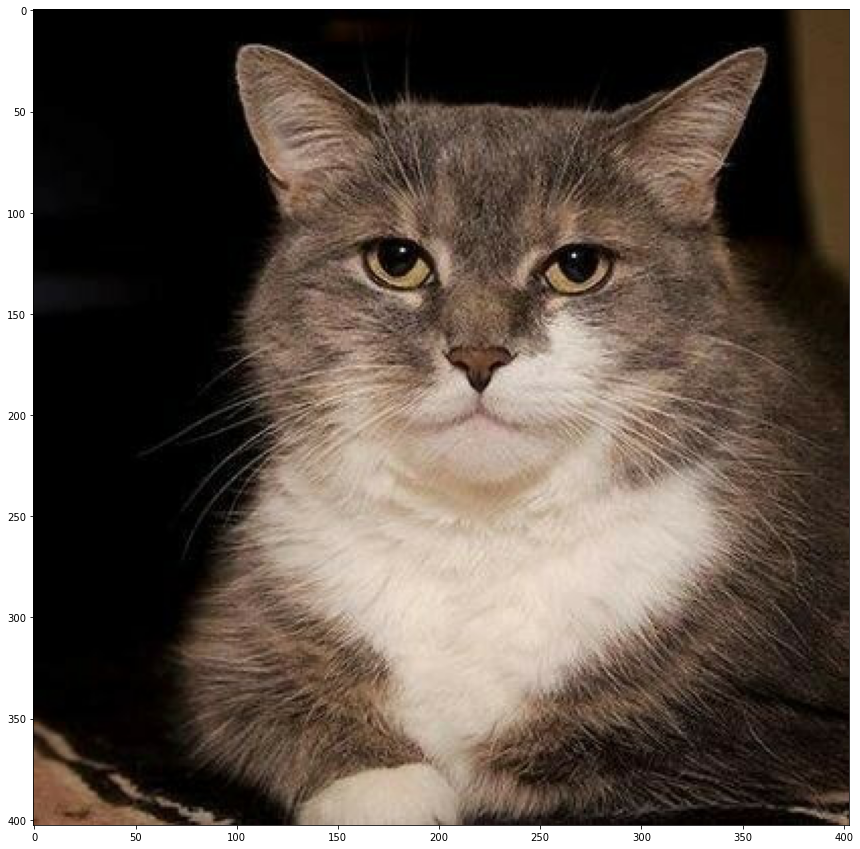

In [2]:
image_path = 'nagnetalka.jpg'
img = cv2.imread(image_path)
width, height = img.shape[0], img.shape[1]
plt.figure(figsize = (15,15)) # Извините, не удержался
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 1. Convolution

In [3]:
def conv(img, kernels):
    M = len(kernels)
    res = np.array([np.zeros((img.shape[0], img.shape[1])) for i in range(M)])
    for i in range(M):
        img0, img1, img2 = cv2.split(img)
        res[i] = cv2.filter2D(img0, -1, kernels[i][0]) + cv2.filter2D(img1, -1, kernels[i][1])\
                    + cv2.filter2D(img2, -1, kernels[i][2])
    return res


In [4]:
num_filters = 4 # M
kernels=[np.random.randint(-5, 5, (3, 3, 3)) for m in range(num_filters)]
for ker in kernels:
    print(ker)
    print('------')
    print()


[[[-3  0 -1]
  [ 4 -2 -4]
  [ 0  2  3]]

 [[ 0 -2 -2]
  [ 1  4  4]
  [-2 -5 -4]]

 [[ 2  1  4]
  [-3 -3  4]
  [ 4  2  2]]]
------

[[[-3 -1 -2]
  [ 2 -2  0]
  [ 3  0 -5]]

 [[-3 -5 -5]
  [-1  3  3]
  [-4 -5 -4]]

 [[-5  2  0]
  [-4  4  1]
  [ 0  2 -3]]]
------

[[[ 2  0 -1]
  [-1  4 -2]
  [-1  0 -3]]

 [[ 3 -4  1]
  [-2  2  1]
  [ 3 -2  3]]

 [[ 2  4 -4]
  [ 4  4  1]
  [-3 -1  4]]]
------

[[[-4  0  1]
  [-3 -5  2]
  [-5  2  0]]

 [[-1  1 -5]
  [-5 -3 -1]
  [-2  4 -5]]

 [[-2  2  4]
  [-2 -3  2]
  [ 2  1  2]]]
------



In [5]:
res_conv=conv(img,kernels)
print(res_conv)

[[[  0.   0.   0. ... 255. 255. 255.]
  [  0.   0.   0. ... 255. 255. 255.]
  [  0.   0.   0. ... 255. 255. 255.]
  ...
  [255. 255. 255. ... 255. 255. 255.]
  [ 42.   7. 255. ... 255. 255. 255.]
  [255. 255. 255. ... 255. 255. 255.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  0.   0.   0. ... 254. 254. 254.]
  [  0.   0.   0. ... 254. 254. 254.]
  [  0.   0.   0. ... 254. 254. 254.]
  ...
  [254. 254. 254. ... 254.  40. 254.]
  [254. 254. 254. ... 254. 254. 254.]
  [254. 254. 254. ... 254. 254. 254.]]

 [[  0.   0.   0. ... 255. 255. 255.]
  [  0.   0.   0. ... 255. 255. 255.]
  [  0.   0.   0. ... 255. 255. 255.]
  ...
  [255. 255. 255. ... 255. 255. 255.]
  [255. 255. 255. ... 255. 255. 255.]
  [255. 255. 255. ... 255. 255. 255.]]]


# 2. Normalize

In [6]:
res_norm = np.array([np.zeros((width, height)) for i in range(num_filters)])
for i in range(num_filters):
    res_norm[i] = cv2.normalize(res_conv[i], None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
res_norm.shape

(4, 403, 403)

# 3. ReLu

In [7]:
res_relu = np.array([np.zeros((res_norm.shape[1], res_norm.shape[2])) for i in range(num_filters)])
for m in range (num_filters):
    for i in range (res_norm.shape[1]):
        for j in range (res_norm.shape[2]):
            res_relu[m][i][j]=1/(1+math.exp(-res_norm[m][i][j]))
                
res_relu.shape

(4, 403, 403)

# 4. POOL

In [8]:
def maxpooling(res_rl):
    nw, nh = int(res_rl.shape[1] / 2), int(res_rl.shape[2] / 2)
    res = np.array([np.zeros((nw,nh)) for i in range(num_filters)])
    for m in range(num_filters):
        for i in range(nw):
            for j in range(nh):
                res[m, i, j] = max(res_rl[m, i * 2, j * 2], res_rl[m, i * 2, j * 2 + 1],
                                      res_rl[m, i * 2 + 1, j * 2], res_rl[m, i * 2 + 1, j * 2 + 1])
    return res

res_pool = maxpooling(res_relu)

nw,nh = res_pool.shape[1],res_pool.shape[2]
res_pool.shape

(4, 201, 201)

# 5. Softmax

In [9]:
def softmax(res_pl):
    res = np.zeros(res_pl.shape, dtype=np.float64)
    for m in range(num_filters):
         for i in range(nw):
            si=np.exp(res_pl[m][i]).sum()
            for j in range(nh):
                res[m][i][j]=math.exp(res_pl[m][i][j])/si
    return res

res_sm = softmax(res_pool)
res_sm.shape

(4, 201, 201)

Выходные каналы: res_sm[i]